In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/cover_type_updated_soil_features.csv')
df.head()

,Unnamed: 0,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type39,Soil_Type40,Cover_Type,Inceptisols,Mollisols,Spodosols,Alfisols,Entisols,Unknown,Histosols
0,0,2596,51,3,258,0,510,221,232,148,...,0,0,5,1,0,0,0,0,0,0
1,1,2590,56,2,212,-6,390,220,235,151,...,0,0,5,1,0,0,0,0,0,0
2,2,2804,139,9,268,65,3180,234,238,135,...,0,0,2,0,0,0,0,1,0,0
3,3,2785,155,18,242,118,3090,238,238,122,...,0,0,2,1,0,0,0,0,0,0
4,4,2595,45,2,153,-1,391,220,234,150,...,0,0,5,1,0,0,0,0,0,0


In [2]:
df.drop('Unnamed: 0',axis = 1,inplace = True)

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split
def split_data(df,y,test_size):
  xtrain,x_test,y_train,y_test = train_test_split(df.drop(y,axis = 1),df[y],test_size = test_size)
  return xtrain,x_test,y_train,y_test

In [5]:
df['Aspect'].shape

(581012,)

In [6]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(df['Aspect'].values.reshape(-1, 1))

# Generate a unimodal distribution using the means and standard deviations of the component distributions
means, stds = gmm.means_, np.sqrt(gmm.covariances_).reshape(-1)
unimodal_data = norm.rvs(loc=means.mean(), scale=stds.mean(), size=581012)

(array([1.90000e+01, 6.38000e+02, 9.95900e+03, 6.39460e+04, 1.77349e+05,
        2.04619e+05, 1.01428e+05, 2.11450e+04, 1.85800e+03, 5.10000e+01]),
 array([-84.58702392, -33.05003004,  18.48696383,  70.0239577 ,
        121.56095158, 173.09794545, 224.63493932, 276.1719332 ,
        327.70892707, 379.24592094, 430.78291482]),
 <BarContainer object of 10 artists>)

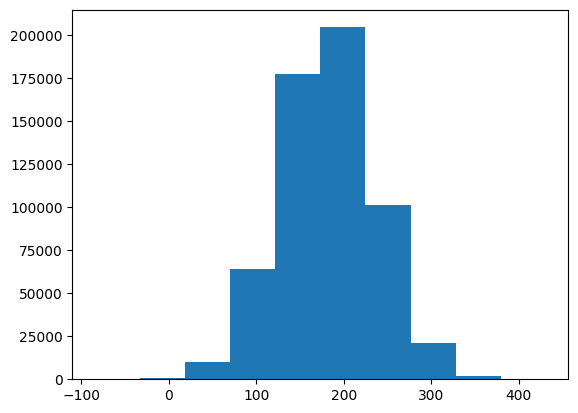

In [7]:
plt.hist(unimodal_data)

In [8]:
unimodal_data.shape

(581012,)

In [9]:
df['Aspect_unimodal'] = unimodal_data

In [10]:
df['Aspect_unimodal']

0         174.044114
1         142.686833
2         258.879805
3         167.944296
4         198.518107
             ...    
581007    172.264464
581008    245.699393
581009    189.149360
581010    204.722524
581011    201.206414
Name: Aspect_unimodal, Length: 581012, dtype: float64

In [11]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(df,column_list):
  for i in column_list:
    tf = StandardScaler()
    df[i] = tf.fit_transform(df[i].values.reshape(-1,1))
  return df

In [12]:
df = standard_scaling(df,['Aspect_unimodal'])

(array([1.90000e+01, 6.38000e+02, 9.95900e+03, 6.39460e+04, 1.77349e+05,
        2.04619e+05, 1.01428e+05, 2.11450e+04, 1.85800e+03, 5.10000e+01]),
 array([-4.97943162, -4.01740846, -3.0553853 , -2.09336215, -1.13133899,
        -0.16931583,  0.79270732,  1.75473048,  2.71675364,  3.67877679,
         4.64079995]),
 <BarContainer object of 10 artists>)

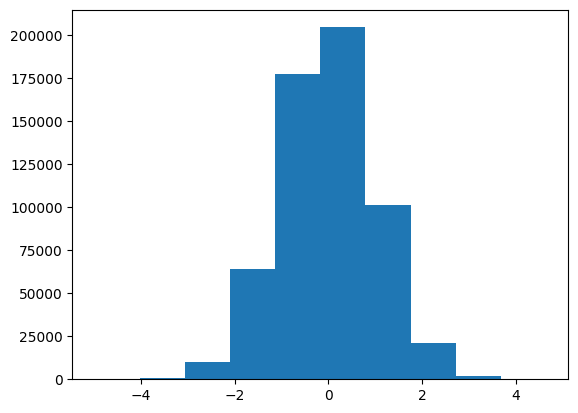

In [13]:
plt.hist(df['Aspect_unimodal'])

In [14]:
df = standard_scaling(df,['Vertical_Distance_To_Hydrology'])

In [15]:
for i in range(0,len(df['Horizontal_Distance_To_Roadways'])):
  if df['Horizontal_Distance_To_Roadways'][i] == 0:
    df['Horizontal_Distance_To_Roadways'][i] = 0.1

<ipython-input-15-41d369b540d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizontal_Distance_To_Roadways'][i] = 0.1


In [16]:
for i in range(0,len(df['Horizontal_Distance_To_Fire_Points'])):
  if df['Horizontal_Distance_To_Fire_Points'][i] == 0.000000:
    df['Horizontal_Distance_To_Fire_Points'][i] = 0.1

<ipython-input-16-9e6d83ef634a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Horizontal_Distance_To_Fire_Points'][i] = 0.1


In [17]:
df['Horizontal_Distance_To_Fire_Points'].describe()

count    581012.000000
mean       1980.291235
std        1324.195197
min           0.100000
25%        1024.000000
50%        1710.000000
75%        2550.000000
max        7173.000000
Name: Horizontal_Distance_To_Fire_Points, dtype: float64

In [18]:
def log_transform(df,feature_list):
  for i in feature_list:
    df[i] = np.log10(df[i])
  return df

In [19]:
df = log_transform(df,['Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points'])

In [20]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(dfa,column_list):
  for i in column_list:
    tf = StandardScaler()
    dfa[i] = tf.fit_transform(dfa[i].values.reshape(-1,1))
  return dfa

In [21]:
df = standard_scaling(df,['Horizontal_Distance_To_Hydrology','Elevation','Slope','Vertical_Distance_To_Hydrology','Hillshade_9am','Hillshade_Noon','Hillshade_3pm'])

In [22]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type40,Cover_Type,Inceptisols,Mollisols,Spodosols,Alfisols,Entisols,Unknown,Histosols,Aspect_unimodal
0,-1.297805,51,-1.482820,-0.053767,-0.796273,2.707570,0.330743,0.439143,0.142960,3.797890,...,0,5,1,0,0,0,0,0,0,-0.151654
1,-1.319235,56,-1.616363,-0.270188,-0.899197,2.591065,0.293388,0.590899,0.221342,3.794139,...,0,5,1,0,0,0,0,0,0,-0.736990
2,-0.554907,139,-0.681563,-0.006719,0.318742,3.502427,0.816364,0.742654,-0.196691,3.786822,...,0,2,0,0,0,0,1,0,0,1.431944
3,-0.622768,155,0.520322,-0.129044,1.227908,3.489958,0.965786,0.742654,-0.536343,3.793162,...,0,2,1,0,0,0,0,0,0,-0.265517
4,-1.301377,45,-1.616363,-0.547771,-0.813427,2.592177,0.293388,0.540313,0.195215,3.790426,...,0,5,1,0,0,0,0,0,0,0.305193


In [23]:
df = standard_scaling(df,['Aspect'])

In [24]:
df.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [25]:
base_features = df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type']]

In [26]:
top_30_features = df[['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type2', 'Soil_Type4', 'Soil_Type10', 'Soil_Type12',
       'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type29',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type38', 'Inceptisols',
       'Mollisols', 'Spodosols', 'Alfisols', 'Entisols',
       'Aspect_unimodal','Cover_Type']]

In [27]:
top_30_features_x_train = top_30_features.drop('Cover_Type',axis = 1)

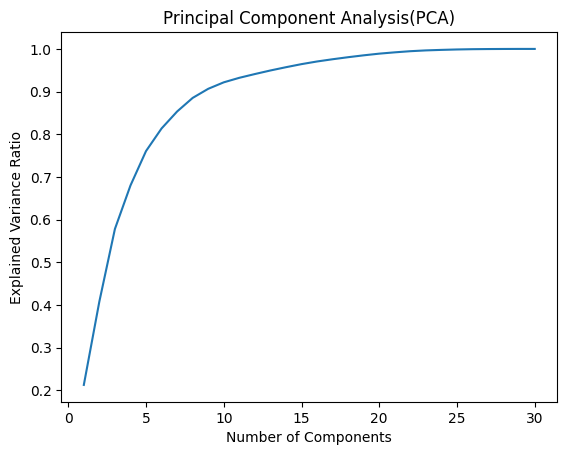

In [129]:
pca = PCA(n_components=30)
pca.fit(top_30_features.drop('Cover_Type',axis = 1))

import matplotlib.pyplot as plt
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
plt.title("Principal Component Analysis(PCA)")
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [130]:
# Get the explained variance ratio of each principal component
explained_var_ratio = pca.explained_variance_ratio_

# Create a dictionary with column names as keys and explained variance ratios as values
var_dict = dict(zip(top_30_features_x_train.columns, explained_var_ratio))

# Sort the dictionary in descending order of explained variance ratios
sorted_var_dict = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1], reverse=True)}

# Print the sorted dictionary
print(sorted_var_dict)

{'Elevation': 0.212515136000885, 'Slope': 0.1956886422179673, 'Horizontal_Distance_To_Hydrology': 0.169909034275033, 'Vertical_Distance_To_Hydrology': 0.10184500872103627, 'Horizontal_Distance_To_Roadways': 0.08064850693020297, 'Hillshade_9am': 0.052975731430325385, 'Hillshade_Noon': 0.039761586460196854, 'Hillshade_3pm': 0.03183899546244066, 'Horizontal_Distance_To_Fire_Points': 0.021325083568029608, 'Wilderness_Area1': 0.0151934523197324, 'Wilderness_Area2': 0.010590147025180852, 'Wilderness_Area3': 0.00882163119905595, 'Wilderness_Area4': 0.0083785899897582, 'Soil_Type2': 0.007652696347474501, 'Soil_Type4': 0.007206593474062202, 'Soil_Type10': 0.006224811314451438, 'Soil_Type12': 0.00522685453847358, 'Soil_Type22': 0.004801408063695018, 'Soil_Type23': 0.004391681293744523, 'Soil_Type24': 0.0039343735733930315, 'Soil_Type29': 0.003065467348266264, 'Soil_Type32': 0.002672607650115628, 'Soil_Type33': 0.0018721947836144504, 'Soil_Type38': 0.001205112214654928, 'Inceptisols': 0.000974560

In [131]:
explained_var_ratio

array([2.12515136e-01, 1.95688642e-01, 1.69909034e-01, 1.01845009e-01,
       8.06485069e-02, 5.29757314e-02, 3.97615865e-02, 3.18389955e-02,
       2.13250836e-02, 1.51934523e-02, 1.05901470e-02, 8.82163120e-03,
       8.37858999e-03, 7.65269635e-03, 7.20659347e-03, 6.22481131e-03,
       5.22685454e-03, 4.80140806e-03, 4.39168129e-03, 3.93437357e-03,
       3.06546735e-03, 2.67260765e-03, 1.87219478e-03, 1.20511221e-03,
       9.74560215e-04, 6.48544890e-04, 3.40059205e-04, 1.90026205e-04,
       1.01463284e-04, 4.19112206e-32])

In [38]:
c = [2.12515136e-01, 1.95688642e-01, 1.69909034e-01, 1.01845009e-01,
       8.06485069e-02, 5.29757314e-02, 3.97615865e-02, 3.18389955e-02,
       2.13250836e-02, 1.51934523e-02, 1.05901470e-02, 8.82163120e-03,
       8.37858999e-03, 7.65269635e-03, 7.20659347e-03, 6.22481131e-03,
       5.22685454e-03, 4.80140806e-03, 4.39168129e-03, 3.93437357e-03,
       3.06546735e-03, 2.67260765e-03, 1.87219478e-03, 1.20511221e-03,
       9.74560215e-04, 6.48544890e-04, 3.40059205e-04, 1.90026205e-04,
       1.01463284e-04, 4.19112206e-32]

In [39]:
sum  = 0
for i in c:
  sum += i
sum

0.999999999769

In [134]:
x_train,x_test,y_train,y_test = split_data(base_features,'Cover_Type',0.3)

In [135]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size = 0.2)

In [136]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_cv = le.fit_transform(y_cv)
y_test = le.fit_transform(y_test)

Model based on all features

In [137]:
model = RandomForestClassifier()

In [138]:
model.fit(x_train, y_train)

RandomForestClassifier()

In [139]:
pred=model.predict(x_test)

In [140]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     63671
           1       0.94      0.97      0.96     84869
           2       0.93      0.96      0.94     10715
           3       0.92      0.84      0.88       794
           4       0.93      0.73      0.82      2813
           5       0.92      0.88      0.90      5198
           6       0.97      0.93      0.95      6244

    accuracy                           0.95    174304
   macro avg       0.94      0.89      0.91    174304
weighted avg       0.95      0.95      0.95    174304



Model on top 30 features(with balanced class)

In [28]:
x_train,x_test,y_train,y_test = split_data(top_30_features,'Cover_Type',0.3)

In [29]:
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size = 0.2)

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
oversample = SMOTE()
X_train_smote, Y_train_smote = oversample.fit_resample(x_train, y_train)

In [32]:
Y_train_smote.value_counts()

1    158513
6    158513
7    158513
2    158513
3    158513
5    158513
4    158513
Name: Cover_Type, dtype: int64

In [33]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_cv = le.fit_transform(y_cv)
Y_train_smote = le.fit_transform(Y_train_smote)

In [34]:
y_test = le.fit_transform(y_test)

In [35]:
best_rf_model = RandomForestClassifier(n_estimators=200,criterion='gini', max_depth=50,max_features = 'auto')

In [36]:
best_rf_model.fit(X_train_smote, Y_train_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=50, max_features='auto', n_estimators=200)

In [37]:
pred=best_rf_model.predict(x_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     63633
           1       0.96      0.96      0.96     84958
           2       0.92      0.95      0.94     10794
           3       0.87      0.88      0.88       789
           4       0.82      0.89      0.85      2885
           5       0.85      0.91      0.88      5116
           6       0.94      0.97      0.95      6129

    accuracy                           0.95    174304
   macro avg       0.90      0.93      0.92    174304
weighted avg       0.95      0.95      0.95    174304



With best 30 features and feature engineering, we got 0.92 F1 macro score